<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/unluckid/model/blob/main/tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 설정

In [1]:
import gdown
import numpy as np
import cv2
import numpy as np
import os
import shutil

file_id = '1e-ovYZtdJVMLnaK_469TWhSXSdHoLHQx'
download_url = f'https://drive.google.com/uc?id={file_id}'

file_id1 = '1UEKiSEIxx_xWLVJfuI8HwkL8TudHv8CT'
download_url1 = f'https://drive.google.com/uc?id={file_id1}'
gdown.download(download_url, '/content/dataset.zip', quiet=False)
gdown.download(download_url1, '/content/test.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1e-ovYZtdJVMLnaK_469TWhSXSdHoLHQx
From (redirected): https://drive.google.com/uc?id=1e-ovYZtdJVMLnaK_469TWhSXSdHoLHQx&confirm=t&uuid=50bfb792-7e7c-425e-9d43-b4deec67242e
To: /content/dataset.zip
100%|██████████| 220M/220M [00:02<00:00, 90.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1UEKiSEIxx_xWLVJfuI8HwkL8TudHv8CT
From (redirected): https://drive.google.com/uc?id=1UEKiSEIxx_xWLVJfuI8HwkL8TudHv8CT&confirm=t&uuid=0030bbbc-4d60-4f35-b8a8-eff9088efd45
To: /content/test.zip
100%|██████████| 32.0M/32.0M [00:00<00:00, 88.2MB/s]


'/content/test.zip'

In [2]:
import zipfile


zip_file_path = '/content/dataset.zip'
extract_path = '/content/'
zip_file_path1 = '/content/test.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
with zipfile.ZipFile(zip_file_path1, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"압축이 {extract_path}에 해제되었습니다.")

압축이 /content/에 해제되었습니다.


In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier,BaggingClassifier
from tensorflow.keras.applications import VGG16, Xception , InceptionV3
from tensorflow.keras.models import load_model, Model
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score


In [8]:
train_dir = "datasets/train"
test_dir = "tset"
val_dir = "datasets/val"
# 데이터 증강 (학습 데이터에만 적용)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,       # 회전 범위 증가
)

# 검증 데이터는 증강하지 않음 (단순히 정규화만 적용)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 학습 데이터 생성기
train_generator = train_datagen.flow_from_directory(
    train_dir,  # 학습 데이터 경로
    target_size=(224, 224),  # VGG16의 입력 크기에 맞게 리사이즈
    batch_size=32,
    class_mode='categorical',  # 다중 클래스 분류
    shuffle=True
)

# 검증 데이터 생성기
val_generator = val_datagen.flow_from_directory(
    val_dir,  # 검증 데이터 경로
    target_size=(224, 224),  # VGG16의 입력 크기에 맞게 리사이즈
    batch_size=32,
    class_mode='categorical'  # 다중 클래스 분류
)
test_generator = test_datagen.flow_from_directory(
    val_dir,  # 검증 데이터 경로
    target_size=(224, 224),  # VGG16의 입력 크기에 맞게 리사이즈
    batch_size=32,
    class_mode='categorical'  # 다중 클래스 분류
)
# tf.data.Dataset으로 변환
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.float32)
    )
)
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.float32)
    )
)
train_dataset = train_dataset.repeat()  # 학습 데이터 무한 반복
val_dataset = val_dataset.repeat()      # 검증 데이터 무한 반복


Found 2625 images belonging to 10 classes.
Found 476 images belonging to 10 classes.
Found 476 images belonging to 10 classes.


In [5]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모델에 Flatten 레이어 추가
x = layers.Flatten()(vgg16_base.output)

# Dense 레이어 추가 (출력 클래스 수에 맞게)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.6)(x)  # Dropout 추가
x = layers.Dense(10, activation='softmax')(x)

# 새로운 모델 정의
model = models.Model(inputs=vgg16_base.input, outputs=x)

# VGG16의 base 일부 레이어를 학습 가능하게 만들기
for layer in vgg16_base.layers:
    layer.trainable = False
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,565,386 (105.15 MB)

 Trainable params: 12,850,698 (49.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
# steps_per_epoch, validation_steps 설정
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

In [7]:
history = model.fit(
    train_dataset,  # tf.data.Dataset 사용
    steps_per_epoch=steps_per_epoch,  # 배치 크기에 맞춰 학습 스텝 설정
    epochs=20,  # 에포크 수
    validation_data=val_dataset,  # 검증 데이터
    validation_steps=validation_steps  # 검증 배치 크기 맞추기
)

# 모델 저장
model.save('vgg16.keras')

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 472ms/step - accuracy: 0.1675 - loss: 4.3554 - val_accuracy: 0.5112 - val_loss: 1.7411
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 55s 641ms/step - accuracy: 0.3395 - loss: 1.8176 - val_accuracy: 0.6059 - val_loss: 1.4947
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 535ms/step - accuracy: 0.3838 - loss: 1.6340 - val_accuracy: 0.7432 - val_loss: 1.1851
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 484ms/step - accuracy: 0.4441 - loss: 1.4535 - val_accuracy: 0.8266 - val_loss: 0.9811
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 36s 446ms/step - accuracy: 0.4516 - loss: 1.4288 - val_accuracy: 0.8198 - val_loss: 0.9944
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.4696 - loss: 1.3582 - val_accuracy: 0.7185 - val_loss: 1.0361
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 489ms/step - accuracy: 0.4566 - loss: 1.3789 - val_accuracy: 0.6757 - val_loss: 1.0274
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - accuracy: 0.4933 - loss: 1.3059 - val_accu

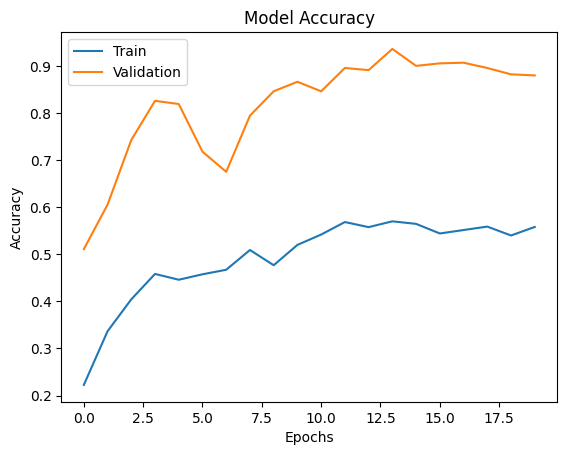

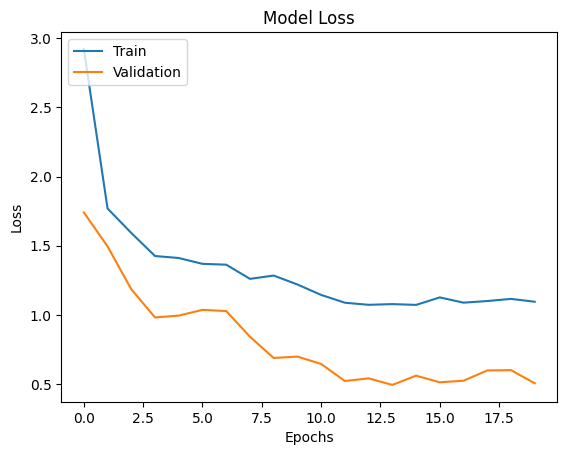

In [9]:
# 학습 결과 시각화
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 학습 및 검증 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


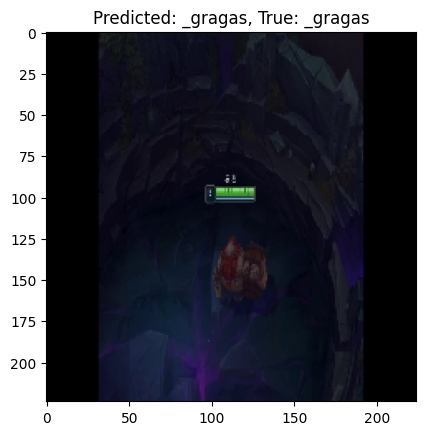

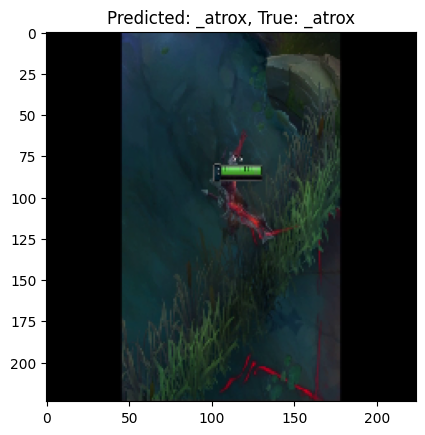

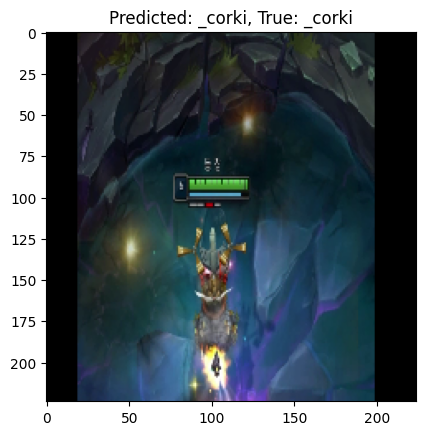

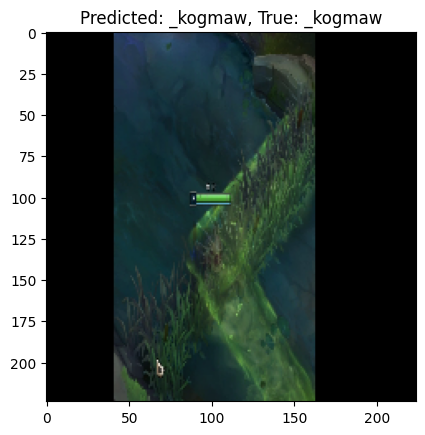

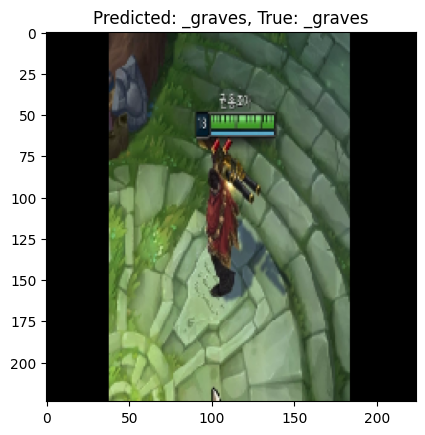

In [ ]:
# 클래스 이름 정의 (train_generator에서 클래스 이름 가져오기)
class_names = list(train_generator.class_indices.keys())

# 검증 데이터에서 몇 개의 이미지를 선택
sample_images, sample_labels = next(val_generator)

# 모델의 예측 결과
predictions = model.predict(sample_images)

# 예측한 클래스 인덱스를 얻고 실제 클래스와 비교
predicted_class = np.argmax(predictions, axis=1)

# 이미지와 예측 결과를 시각화
for i in range(5):  # 예시로 5개 이미지만 출력
    plt.imshow(sample_images[i])
    true_class = np.argmax(sample_labels[i])
    plt.title(f"Predicted: {class_names[predicted_class[i]]}, True: {class_names[true_class]}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


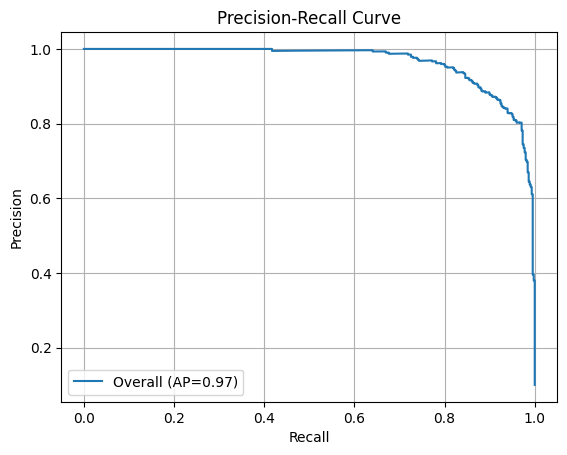

In [10]:


# test 데이터에 대한 예측
y_true = []
y_scores = []

# val_generator에서 예측 수행
for i in range(validation_steps):
    x_batch, y_batch = next(test_generator)  # 수정: next() 사용
    y_true.extend(np.argmax(y_batch, axis=1))  # 실제 라벨
    y_scores.extend(model.predict(x_batch))   # 예측 확률

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# 이진 분류로 처리: 모든 클래스의 예측을 하나로 합침 (softmax의 출력이므로 각 클래스의 예측 확률을 합침)
# y_true는 원핫 인코딩된 형태이므로, 이를 binary 형식으로 변환
y_true_binary = np.zeros_like(y_scores)
for i in range(len(y_true)):
    y_true_binary[i, y_true[i]] = 1

# 전체 Precision-Recall 곡선 계산 (여기서는 모든 클래스에 대한 예측을 합침)
precision, recall, _ = precision_recall_curve(y_true_binary.ravel(), y_scores.ravel())
average_precision = average_precision_score(y_true_binary.ravel(), y_scores.ravel())

# Precision-Recall 곡선 시각화
plt.plot(recall, precision, label=f'Overall (AP={average_precision:.2f})')

# 전체 스타일 설정
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid()
plt.show()
